In [1]:
!pip install blackjax

In [2]:
import numpy as np
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
import time as t
from datetime import date
import jax
import jax.numpy as jnp
import blackjax

In [3]:
class SoftSpherePacking:
  def __init__(self, number_balls, dimensions, radius, bounding_box_size=1., alpha=0.4, beta=1., attractive=True):
    self.number_balls = number_balls
    self.dimensions = dimensions
    self.radius = radius
    self.bounding_box_size = bounding_box_size
    self.alpha = alpha
    self.beta = beta
    self.attractive = attractive
    self.A = np.zeros([int(self.number_balls * (self.number_balls - 1) / 2), self.number_balls])
    self.origin = np.zeros((self.number_balls, self.dimensions)) + self.bounding_box_size / 2

    row = 0
    for i in range(self.number_balls - 1, 0, -1):
        self.A[row : row + i, self.number_balls - 1 - i] = np.ones(i)
        self.A[row : row + i, self.number_balls - i : self.number_balls] = -np.eye(i)
        row += i

  def cost(self, data):
    bounded_data = jnp.mod(data.copy(), self.bounding_box_size)
    if self.attractive:
      cost_overlap = -(self.beta * jnp.sum(jnp.sqrt(jnp.sum((bounded_data - self.origin) ** 2, axis=1))) / self.number_balls) + self.alpha * (self.beta * jnp.sum(jnp.sqrt(jnp.sum((bounded_data[1:] - bounded_data[:-1]) ** 2, axis=1))) / self.number_balls)
    else:
      cost_overlap = self.beta * jnp.sum(jnp.sqrt(jnp.sum((bounded_data - self.origin) ** 2, axis=1))) / self.number_balls
    return cost_overlap

In [4]:
# global constants for sampling algorithm
DEFAULT_WARMUP_TIME = 1000
DEFAULT_STEP_SIZE = 0.033

class NutsWindowAdapt:
  def __init__(self, problem_instance, initial_position, warmup=True, warmup_time=DEFAULT_WARMUP_TIME):
    self.call_cost_function = lambda x : problem_instance.cost(**x)
    self.initial_position = initial_position
    self.warmup = warmup
    self.rng_key = jax.random.key(int(date.today().strftime("%Y%m%d")))

    if warmup:
      warmup_sampler = blackjax.window_adaptation(blackjax.nuts, self.call_cost_function)
      _, warmup_key, self.sample_key = jax.random.split(self.rng_key, 3)
      (self.state, self.parameters), _ = warmup_sampler.run(warmup_key, self.initial_position, num_steps=warmup_time)

  def inference_loop(self, rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)
    return states

  def run(self, run_time, inverse_mass_matrix, step_size=DEFAULT_STEP_SIZE):
    if self.warmup:
      kernel = blackjax.nuts(self.call_cost_function, **self.parameters).step
      states = self.inference_loop(self.sample_key, kernel, self.state, run_time)
    else:
      nuts_sampler = blackjax.nuts(self.call_cost_function, step_size, inverse_mass_matrix)
      initial_state = nuts_sampler.init(self.initial_position)
      _, sample_key = jax.random.split(self.rng_key)
      states = self.inference_loop(sample_key, nuts_sampler.step, initial_state, run_time)
    return states

In [5]:
# constants for soft spheres
number_balls = 25
dimensions = 2
radius = 0.1
bounding_box_size = radius * 10.
run_time = 500
bins = np.linspace(0, np.sqrt(dimensions), 150)

if dimensions == 2:
  # alternate, not random initial condition in 2 dimensions
  theta = np.linspace(0, 2 * np.pi, number_balls + 1)[:-1]
  initial_data = np.zeros((number_balls, dimensions))
  initial_data[:, 0] = bounding_box_size * np.cos(theta) / 3 + bounding_box_size / 2
  initial_data[:, 1] = bounding_box_size * np.sin(theta) / 3 + bounding_box_size / 2
else:
  initial_data = bounding_box_size * np.random.rand(number_balls, dimensions)

initial_position = {"data": initial_data}
default_inverse_mass_matrix = np.ones(len(initial_position.keys()))

In [6]:
# correlation function data
g2_data = list()

# empirical critical alpha
alpha = 0.44

for beta in np.concatenate([2 ** np.linspace(-1, 7, 9), np.linspace(256, 512, 9)]):
  start_time = t.time()
  ssp = SoftSpherePacking(number_balls, dimensions, radius, alpha=alpha, beta=beta)
  nwa = NutsWindowAdapt(ssp, initial_position, warmup=False)
  history = nwa.run(run_time=run_time, inverse_mass_matrix=default_inverse_mass_matrix)
  history.position["data"] = np.mod(history.position["data"], 1)
  history = history.position['data']

  plot_data = pdist(np.reshape(history[:], [-1, 2]))
  histogram_data, bins = np.histogram(plot_data.copy(), bins=bins)
  g2_data.append(histogram_data.copy() / (len(plot_data) * (bins[1:]**dimensions - bins[:-1]**dimensions)))
  print(f"alpha: {np.round(alpha, 4)}, beta: {np.round(beta, 4)}, time elapsed: {np.round(t.time() - start_time, 4)}s")

alpha: 0.44, beta: 0.5, time elapsed: 13.3104s
alpha: 0.44, beta: 1.0, time elapsed: 15.1735s
alpha: 0.44, beta: 2.0, time elapsed: 14.7459s
alpha: 0.44, beta: 4.0, time elapsed: 14.9459s
alpha: 0.44, beta: 8.0, time elapsed: 11.4894s
alpha: 0.44, beta: 16.0, time elapsed: 11.3599s
alpha: 0.44, beta: 32.0, time elapsed: 11.4219s
alpha: 0.44, beta: 64.0, time elapsed: 10.9541s
alpha: 0.44, beta: 128.0, time elapsed: 12.3175s
alpha: 0.44, beta: 256.0, time elapsed: 10.7136s
alpha: 0.44, beta: 288.0, time elapsed: 10.5582s
alpha: 0.44, beta: 320.0, time elapsed: 10.2032s
alpha: 0.44, beta: 352.0, time elapsed: 11.8078s
alpha: 0.44, beta: 384.0, time elapsed: 10.6277s
alpha: 0.44, beta: 416.0, time elapsed: 10.4521s
alpha: 0.44, beta: 448.0, time elapsed: 10.3935s
alpha: 0.44, beta: 480.0, time elapsed: 12.1564s
alpha: 0.44, beta: 512.0, time elapsed: 10.199s


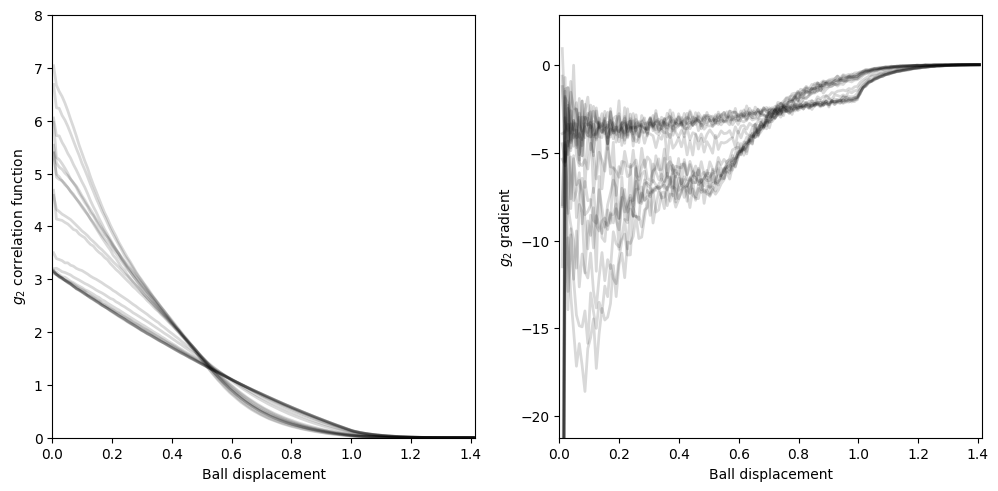

In [7]:
# plotting constants
color='black'
alpha=0.15
linewidth=2

# plotting data
xaxis = (bins[1:] + bins[:-1])/2
gradient_xaxis = (xaxis[1:] + xaxis[:-1])/2
g2_data = np.array(g2_data)

# plot
fig, ax = plt.subplots(ncols=2, figsize=(12, 6))

for i in range(len(g2_data)):
  ax[0].plot(xaxis[:], g2_data[i], alpha=alpha, color=color, linewidth=linewidth)
  gradient_g2_data = (g2_data[i,1:] - g2_data[i,:-1]) / (bins[2] - bins[1])
  ax[1].plot(gradient_xaxis, gradient_g2_data, alpha=alpha, color=color, linewidth=linewidth)

# plot formatting
ax[0].set_xlim([0, np.sqrt(2)])
ax[0].set_xlabel("Ball displacement")
ax[0].set_ylim([0, 8])
ax[0].set_ylabel(r"$g_2$ correlation function")
ax[0].set_aspect(np.sqrt(2)/8)

ax[1].set_xlim([0, np.sqrt(2)])
ax[1].set_xlabel("Ball displacement")
ax[1].set_ylim([-15 * np.sqrt(2), 2 * np.sqrt(2)])
ax[1].set_ylabel(r"$g_2$ gradient")
ax[1].set_aspect(1/17)

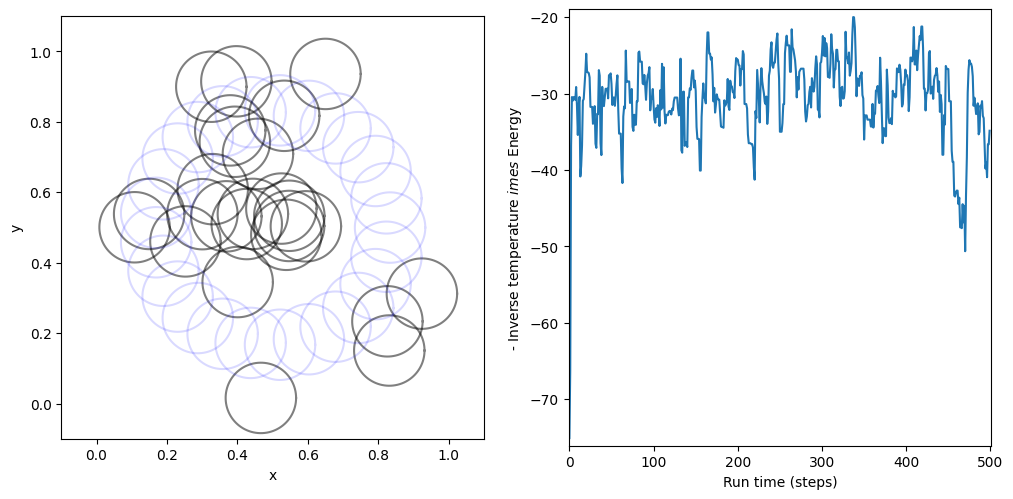

In [8]:
# plots for last alpha and beta tested above
def plot_circles(ax, centers, radii, color='black', alpha=0.5):
    theta = np.linspace(0, 2 * np.pi, 100)
    for i in range(len(centers)):
        ax.plot(radii[i] * np.cos(theta) + centers[i, 0], radii[i] * np.sin(theta) + centers[i, 1], color=color, alpha=alpha)


# plotting data
frame_from_last = 1
radii = radius * np.ones(len(history[-frame_from_last]))
centers_final = history[-frame_from_last]
centers_initial = initial_data
delta_y = 2.
energy_list = list()
for i in range(history.shape[0]):
  energy_list.append(ssp.cost(history[i]))
energy_list = np.array(energy_list)

# plot
fig, ax = plt.subplots(ncols=2, width_ratios=[1, 1], figsize=(12, 6))

plot_circles(ax[0], centers_final, radii)
plot_circles(ax[0], centers_initial, radii, 'blue', alpha=alpha)

ax[1].plot(energy_list)

# plot formatting
ax[0].set_xlim([0 - radius, bounding_box_size + radius])
ax[0].set_xlabel("x")
ax[0].set_ylim([0 - radius, bounding_box_size + radius])
ax[0].set_ylabel("y")
ax[0].set_aspect("equal")

ax[1].set_xlim([-1, run_time+1])
ax[1].set_xlabel("Run time (steps)")
ax[1].set_ylim([np.min(energy_list) - delta_y / 2, np.max(energy_list) + delta_y / 2])
ax[1].set_ylabel("- Inverse temperature $\times$ Energy")
ax[1].set_aspect(np.abs(run_time / (np.max(energy_list) - np.min(energy_list))))